In [1]:
!pip install pandas pandas-ta

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

In [3]:
history = pd.read_csv('./AMZN.csv')

In [4]:
# Reverse dataframe to sort prices by date, ascending order
history = history.iloc[::-1]
history = history.reset_index(drop=True)
#history = history.iloc[365:730]
history = history.iloc[0:730]
history = history.reset_index(drop=True)

In [5]:
history

,Date,Close,Volume,Open,High,Low
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.2250
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.1740
2,08/20/2013,14.3545,31705200,14.2940,14.4758,14.2870
3,08/21/2013,14.2285,36301420,14.2545,14.4250,14.1915
4,08/22/2013,14.4865,28451720,14.2400,14.4935,14.2400
...,...,...,...,...,...,...
725,07/05/2016,36.4050,48524080,36.1400,36.4780,35.9805
726,07/06/2016,36.8805,78597800,36.2855,36.8885,36.1290
727,07/07/2016,36.8285,58786080,36.9665,36.9775,36.5815
728,07/08/2016,37.2905,68543940,37.0070,37.3050,36.9000


In [6]:
WINDOW_SIZE = 2

# Initial window/preliminary data
df = history.iloc[0:WINDOW_SIZE]

In [7]:
def compute_indicators(df):
    df = df.copy()

    def get_indicator(name):
        if len(df) < 35:
            return -1
        values = ta.macd(df['Close'])
        if values is None:
            return -1
        return values.where(np.isfinite, -1)[name] + 10

    df.loc[:, "MACD"] = get_indicator("MACD_12_26_9")
    df.loc[:, "H"] = get_indicator("MACDh_12_26_9")
    df.loc[:, "S"] = get_indicator("MACDs_12_26_9")
    
    return df

def update_and_recalculate(df, series_index):
    # Get new update to include in frame
    new_data = history.iloc[series_index].copy()

    # Insert row in frame
    df.loc[len(df)] = new_data

    # Compute TA
    return compute_indicators(df)

In [8]:
df = compute_indicators(df)

In [9]:
df

,Date,Close,Volume,Open,High,Low,MACD,H,S
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.225,-1,-1,-1
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.174,-1,-1,-1


In [10]:
window = df.loc[0:1,['Date','Close', 'MACD', 'H', 'S']].to_numpy()
window

array([['08/16/2013', 14.241, -1, -1, -1],
       ['08/19/2013', 14.2785, -1, -1, -1]], dtype=object)

In [11]:
from strategy_macd import MacdBot as Bot
from utils import BotTracker

# Start iterating over the history data. simulates that we gather price data from an external provider
# at every new step/iteration, we add the price data into the dataframe df and recompute TAs
# then we move the window 1 day forward and only pass into the bot that window

start_index = 0

t = BotTracker(start_index + WINDOW_SIZE - 1)
b = Bot(money=5000, events_listener=t)
print(f"Initial money: {b.budget()}")

while start_index < len(history)-WINDOW_SIZE+1:
    df = update_and_recalculate(df, start_index+WINDOW_SIZE-1)
    window = df.loc[start_index:start_index+WINDOW_SIZE-1,['Date','Close', 'MACD', 'H', 'S']].to_numpy()
    #print(f"{start_index+2} => MACD: {window[1][2]}, SIG: {window[1][4]}")
    b.think(window)
    if start_index % 100 == 0:
        print(f"Checkpoint at {start_index}, money: {b.budget()}")
    
    start_index += 1
    t.incr()

date, price = df.loc[(len(df)-1), ['Date', 'Close']]
b.finish(date, price)
print(f"Money at the end: {b.budget()}")
    

Initial money: 5000
Checkpoint at 0, money: 5000
Checkpoint at 100, money: 5000
Closed position, earned: -5%
Checkpoint at 200, money: 4923.955860133823
Closed position, earned: -5%
Closed position, earned: -5%
Checkpoint at 300, money: 4769.222203353526
Closed position, earned: -6%
Checkpoint at 400, money: 3273.7476339950927
Closed position, earned: 35%
Checkpoint at 500, money: 5171.791048856923
Checkpoint at 600, money: 2534.1776139398926
Closed position, earned: 17%
Closed position, earned: 17%
Checkpoint at 700, money: 3940.7139365813955
Closed position, earned: 31%
Money at the end: 6145.153853499925


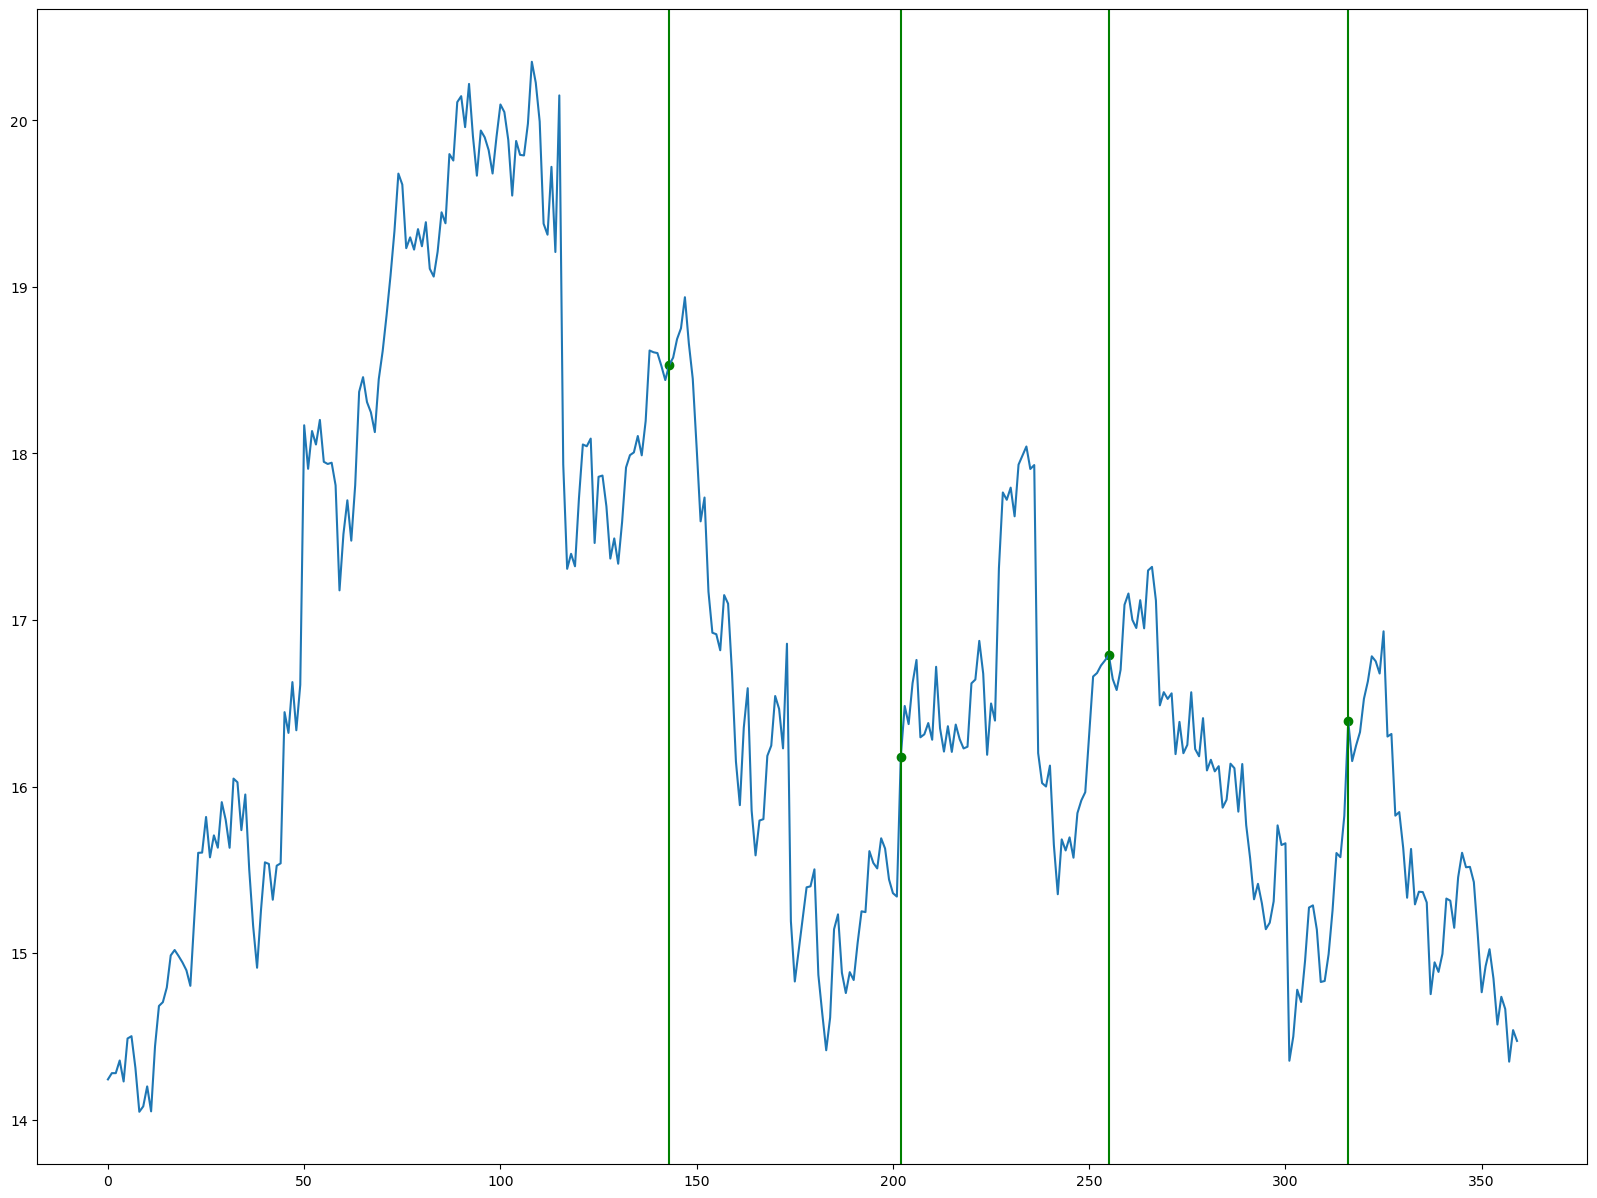

In [12]:
import matplotlib.pyplot as plt

S=0
E=360
#tsignals = ta.adx(df['High'], df['Low'], df['Close']).to_numpy()

prices = df['Close'].to_numpy()
ma20 = df['MACD'].to_numpy()
ma50 = df['H'].to_numpy()
ma100 = df['S'].to_numpy()

plt.figure(figsize=(20, 15))
plt.plot(prices[S:E])
#plt.plot(ma20[S:E])
#plt.plot(ma50[S:E])
#plt.plot(ma100[S:E])
#plt.plot(tsignals[S:E]-100)

opened_positions_data = t.get_for_rendering()
for p in opened_positions_data:
    if p["index"] < S or p["index"] > E:
        continue
    plt.axvline(x=p["index"]-S, color='green')
    plt.scatter(p["index"]-S, p["price"], color="green")

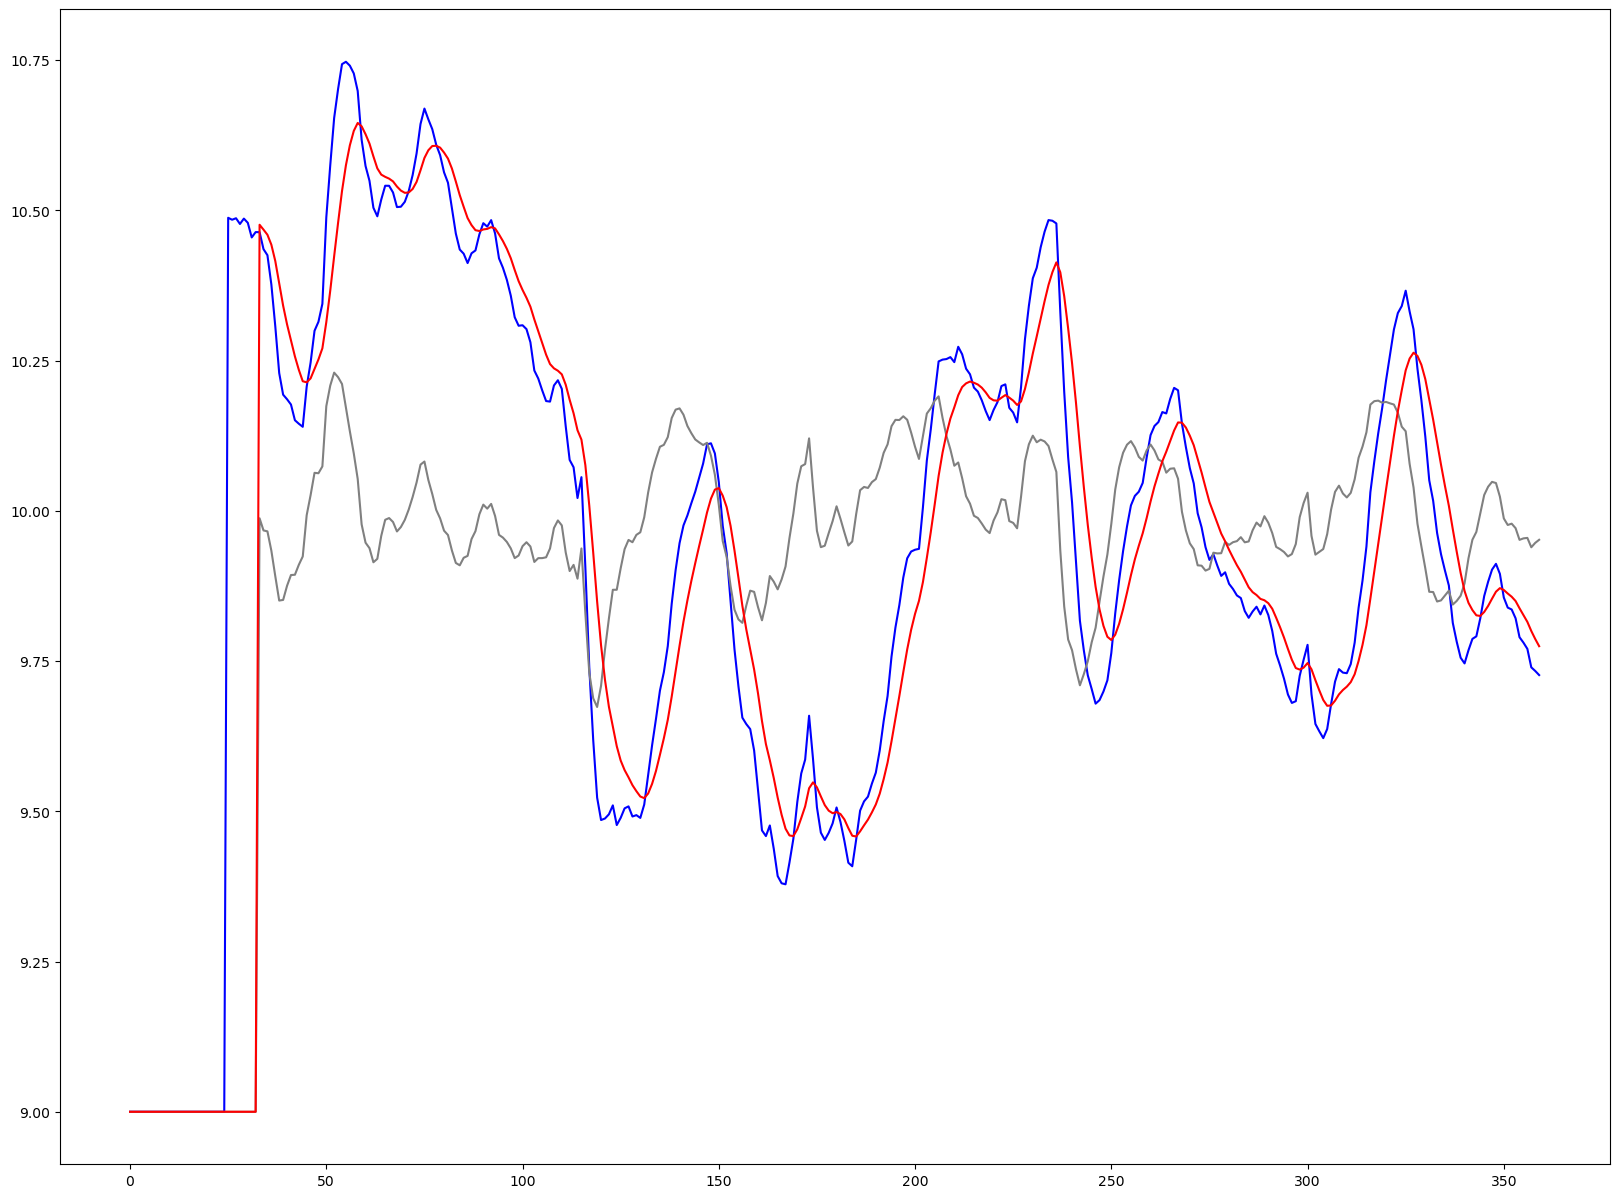

In [13]:
plt.figure(figsize=(20, 15))
plt.plot(ma20[S:E], color='blue')
plt.plot(ma50[S:E], color='gray')
plt.plot(ma100[S:E], color='red')